In [1]:
install.packages(c("pwr", "purrr"))
library(pwr)
library(purrr)

inv.logit <- function(x) {
    1 / (1 + exp(-x))
}

data_causal_inf <- function(n, tau = 1, b = 2, base = 100) {
    ## DGP
    age <- rnbinom(n, 10, 0.3)
    ps <- inv.logit(0.2*(age- mean(age)))
    Y0s <- round(base + b * age + rnorm(n, 0, 3))
    Y1s <- round(Y0s + tau)
    Z <- map_dbl(ps, ~ sample(c(0,1), 1, F, c(1-., .)))
    Y <- Z * Y1s + (1-Z) * Y0s
    return(list(age = age, Y = Y, Z = Z, ps = ps))
}

data_causal_inf_rand_exp <- function(n, tau = 1, b = 2, base = 100) {
    ## DGP
    age <- rnbinom(n, 10, 0.3)
    ps <- inv.logit(0.2*(age- mean(age)))
    Y0s <- round(base + b * age + rnorm(n, 0, 3))
    Y1s <- round(Y0s + tau)
    Z <- rbinom(n, 1, 0.5)
    Y <- Z * Y1s + (1-Z) * Y0s
    return(list(age = age, Y = Y, Z = Z, ps = ps))
}

set.seed(7)
n <- 500

causal_int_obs <- data_causal_inf(n, tau = 0.9123, b = - 1.0314)

Age <- causal_int_obs$age; StreamingMinutes <- causal_int_obs$Y; AccountType <- ifelse(causal_int_obs$Z, "Premium", "Free")
musicfi <- data.frame(Age, AccountType, StreamingMinutes)

causal_int_obsrand <- data_causal_inf_rand_exp(n=500, tau = 0.9123, b = - 0.5314)

Age <- causal_int_obsrand$age; StreamingMinutes <- causal_int_obsrand$Y; AccountType <- ifelse(causal_int_obsrand$Z, "Premium", "Free")
musicfiExp <- data.frame(Age, AccountType, StreamingMinutes)

package 'pwr' successfully unpacked and MD5 sums checked


package 'purrr' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'purrr'"

Warning message:
"restored 'purrr'"


The downloaded binary packages are in
	C:\Users\phamilton\AppData\Local\Temp\RtmpOk4bIA\downloaded_packages


Warning message:
"package 'pwr' was built under R version 3.6.3"

# Observational Studies

The vast majority of statistics courses begin and end with the premise that correlation is not causation. But they rarely explain why we can not directly assume that correlation is not causation.

Let’s consider a simple example. Imagine you are working as a data scientist for Musicfi, a firm that offers on-demand music streaming services. To keep things simple, let’s assume the firm has two account types: a free account and a premium account. Musicfi’s main measure of customer engagement is the total streaming minutes that measure how many minutes each customer spent on the service per day. As a data scientist, you want to understand your customers, so you decide to perform a simple analysis that compares the total streaming minutes across the two account types. To put this in causal terms:

+ Our treatment is having a premium account
+ Our control is having a free account
+ Our outcome is total streaming minutes

Suppose we have a random sample of 500 customers, stored in a data frame called `musicfi`:

In [2]:
head(musicfi)

Age,AccountType,StreamingMinutes
33,Premium,63
38,Premium,61
24,Free,82
28,Premium,72
61,Premium,38
33,Free,71


First, let's create a side-by-side boxplot that compares the `StreamingMinutes` of free and premium customers:

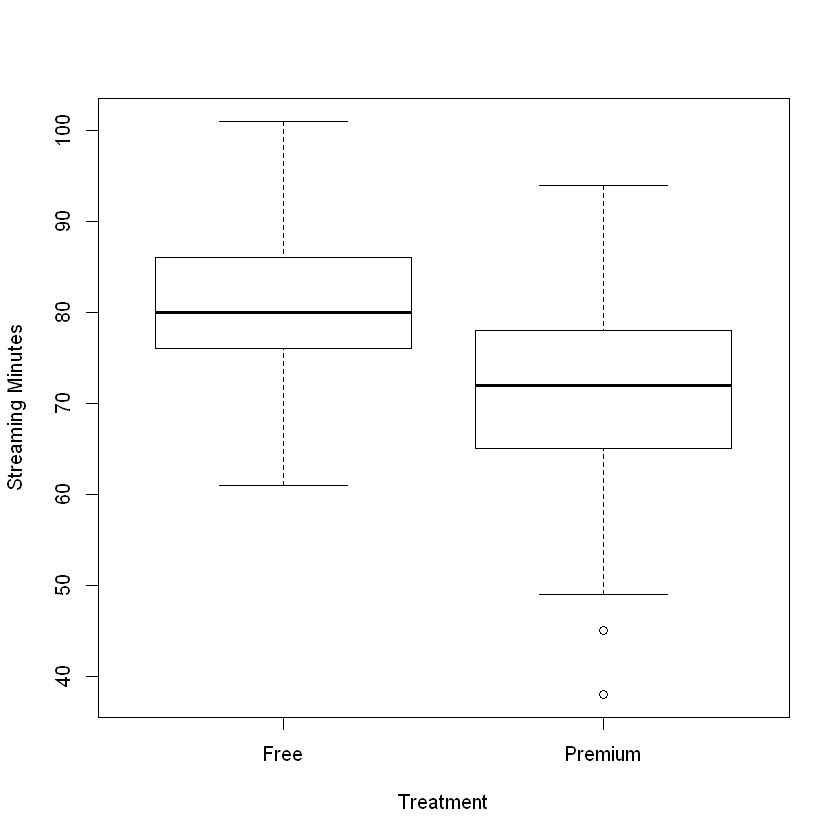

In [3]:
boxplot(musicfi$StreamingMinutes ~ musicfi$AccountType, 
        ylab = "Streaming Minutes", xlab = "Treatment")

From the figure, we can see that the customers with premium accounts had lower total streaming minutes than customers with free accounts! The average in the premium group was 71 minutes compared to 80 minutes in the free group, meaning that (on average) customers with a premium account listened to less music! We can use a t-test to check if this observed difference is statistically significant:

In [4]:
t.test(musicfi$StreamingMinutes ~ musicfi$AccountType)


	Welch Two Sample t-test

data:  musicfi$StreamingMinutes by musicfi$AccountType
t = 11.774, df = 444.24, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  7.52599 10.54174
sample estimates:
   mean in group Free mean in group Premium 
             80.42205              71.38819 


Suppose we take the above results at face value. In that case, we might incorrectly conclude that having a premium account reduces customer engagement. But this seems unlikely! Our general understanding suggests that buying a premium account should have the opposite effect. So what's going on? Well, we are likely falling victim to what is often called **selection bias**. Selection bias occurs when the treatment group is systematically different from the control group before the treatment has occurred, making it hard to disentangle differences due to the treatment from those due to the systematic difference between the two groups.

Mathematically, we can model selection bias as a third variable---often called a confounding variable---associated with both a unit's propensity to receive the treatment and that unit's outcome. In our Musicfi example, this variable could be the age of the customer: younger customers tend to listen to more music and are less likely to purchase a premium account. Therefore, the age variable is a confounding variable as it limits our ability to draw causal inferences.

To see this, we can compare how age is related to total streaming minutes and the account type. First, let's create a scatter plot of age and streaming minutes:

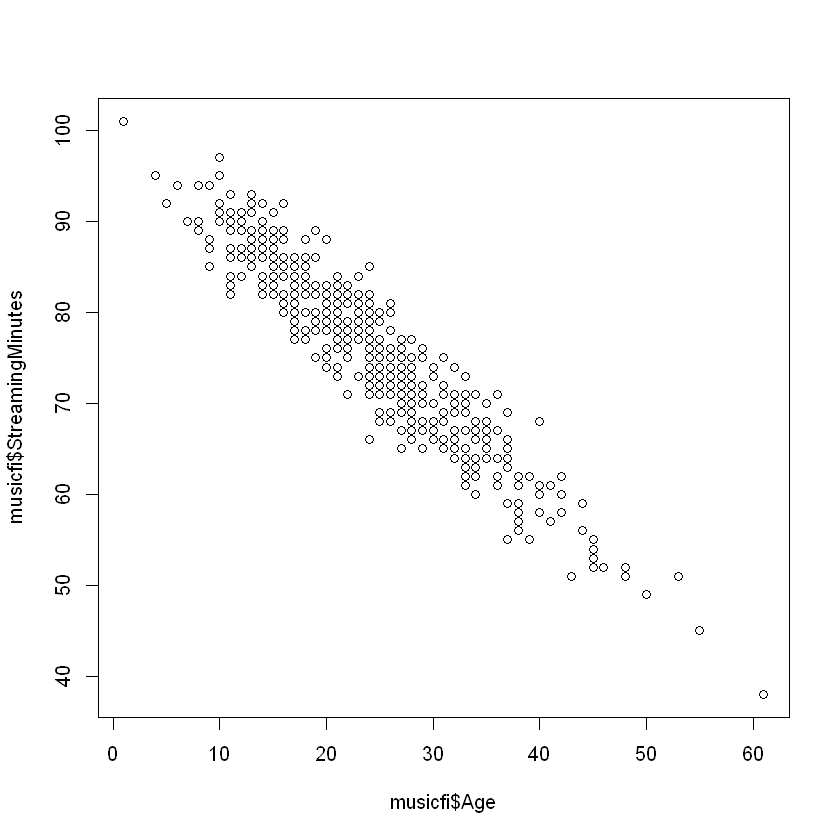

In [5]:
plot(musicfi$Age, musicfi$StreamingMinutes)

If we wanted to adjust for the age variable (assuming it is observed), we could run a linear regression with both `AccountType` and `Age` as independent variables:

In [6]:
summary(lm(StreamingMinutes ~ AccountType + Age, data=musicfi))


Call:
lm(formula = StreamingMinutes ~ AccountType + Age, data = musicfi)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.1032 -2.2259  0.0901  2.0055  8.6514 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        100.57573    0.41028 245.138  < 2e-16 ***
AccountTypePremium   1.51568    0.33928   4.467 9.82e-06 ***
Age                 -1.06136    0.01904 -55.736  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.144 on 497 degrees of freedom
Multiple R-squared:  0.8927,	Adjusted R-squared:  0.8923 
F-statistic:  2068 on 2 and 497 DF,  p-value: < 2.2e-16


From this output, we see that the coefficient on `AccountType` is positive! This means that after controlling for age, premium users actually listen to *more* music, on average. Including `Age` in the regression removes its confounding effect on the relationship between `AccountType` and `StreamingMinutes`. 

However, even after controlling for age, can we be confident in interpreting this as a causal outcome? The answer is still most likely no. That is because there may exist more confounding variables that are not a part of our data set; these are known as **unobserved confounders**. Even if there were no unobserved confounders, there are much more robust methods for analyzing observational studies than linear regression.